
# Zcash Observatory data

Mitchell Krawiec-Thayer and Pranav Thirunavukkarasu

June 2020

Observatory R & D at Insight supported by the Zcash Foundation


## Parameters

In [1]:
path_to_files = '.'
savedata = 1

## Import libraries

In [2]:
import numpy as np;
import matplotlib.pyplot as plt;
import pandas as pd;
import math;
import os;

## Define functions

In [3]:
def Heatmap(x, y, LinBins = (60,60), LogBins = (60,60), title = '', xlabel = '', ylabel = '', yscale = 'linear', xscale = 'linear', onlyplot = '', vmax = 'auto', vmin = 0, clabel='', ymax = 'auto'):
    # import numpy as np
    # import matplotlib.pyplot as plt
    # MPKT 2019.06

    # Note that this is a hacky function that cannot handle NaNs at the moment
    
    if ymax == 'auto':
        ymax_val = np.log10(int(np.max(x)))
    else:
        ymax_val = np.log10(int(ymax))
    
    # Log plot
    if not onlyplot == 'linear':
        fig = plt.figure(figsize=(15,5), facecolor='white')
        if len(LogBins) == 2:
            yedges = np.logspace(np.log10(1),ymax_val, LogBins[1])
        H, xedges, yedges = np.histogram2d(list(x),list(y), bins=(LogBins[1],yedges))
        
        # H needs to be rotated and flipped
        H = np.rot90(H)
        H = np.flipud(H)
        
        if vmax == 'auto':
            vmax = np.max(H)
        # Plot 2D histogram using pcolor
        plt.pcolormesh(xedges,yedges,H,vmax=vmax, vmin=vmin)
        cbar = plt.colorbar()
        cbar.ax.set_ylabel(clabel)                                          
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.xscale(xscale)
        plt.yscale(yscale)
        plt.show()
        
        return fig;

## Import data

In [4]:
# What are the nearby directories
folders = [x[0] for x in os.walk(path_to_files)]

In [5]:
# global_df = pd.DataFrame()
node_names = list()
height_buffer_df = pd.DataFrame()
first_time = 1
for f in range(len(folders)):
    this_folder_raw = folders[f]
    if not (this_folder_raw[0:3] == './.' or this_folder_raw == '.'):
        node_name = this_folder_raw[2::]
        node_names.append(node_name)
        
        # Get timestamp data
        file_name = os.path.join(this_folder_raw,'inv_v1.csv')
        this_df = pd.read_csv(file_name)
        
        # Get height data
        blocks_file_name = os.path.join(this_folder_raw,'blocks_v1.csv')
        temp_block_df = pd.read_csv(blocks_file_name, index_col = 'Hash')
        temp_block_df = temp_block_df.filter(["Hash", "Height"], axis=1)
        height_buffer_df = height_buffer_df.append(temp_block_df)
        
        # Some feature engineering
        min_time = this_df.groupby('Hash').min()
        min_time = min_time.rename(columns={"Validated_Time": node_name+"_min", "Peer_IP": "min_IP", "Hash":'block_hash'})
        max_time = this_df.groupby('Hash').max()
        max_time = max_time.rename(columns={"Validated_Time": node_name+"_max", "Peer_IP": "max_IP", "Hash":'block_hash'})
        single_node_combined = pd.concat([min_time, max_time], axis=1)
        single_node_combined[node_name+'_prop_time'] = single_node_combined[node_name+'_max']-single_node_combined[node_name+'_min']
        single_node_combined = single_node_combined.filter(['block_hash', node_name+"_min", node_name+"_max",node_name+"_prop_time"], axis=1)
        
        if first_time:
            global_df = single_node_combined
            first_time = 0
        else:
            global_df = pd.concat([global_df,single_node_combined], axis=1, sort=False)
            
# add on heights
global_df = pd.concat([global_df, height_buffer_df.drop_duplicates()], axis=1, sort=False)
print(len(global_df))
global_df.head()

1146


,mumbai_min,mumbai_max,mumbai_prop_time,virginia_min,virginia_max,virginia_prop_time,london_min,london_max,london_prop_time,africa_min,africa_max,africa_prop_time,Height
000000000000b86df2619ffbde1d3de76bdf1cc9c73b4acc91dccad6f234ec71,1.590722e+09,1.590722e+09,27.129,1.590722e+09,1.590722e+09,119.911,1.590722e+09,1.590722e+09,26.983,1.590722e+09,1.590722e+09,27.092,847610.0
000000000000bc65600076a474767b0201c02fac53adb217dcafb8f44a3de6e4,1.590754e+09,1.590754e+09,12.173,1.590754e+09,1.590754e+09,12.125,1.590754e+09,1.590754e+09,12.103,1.590754e+09,1.590754e+09,8.697,848039.0
000000000000c32bff2dcb5497f93438548bf10ef1e7ac541b0b0e81a100e1f1,1.590774e+09,1.590774e+09,61.857,1.590774e+09,1.590774e+09,187.656,1.590774e+09,1.590774e+09,61.846,1.590774e+09,1.590774e+09,162.400,848309.0
0000000000016608d92021f3056e25742fc063ff7409fbd80f9cf0d290516a16,1.590711e+09,1.590711e+09,5.704,1.590711e+09,1.590711e+09,3.020,1.590711e+09,1.590711e+09,5.696,1.590711e+09,1.590711e+09,4.580,847471.0
000000000002dd1be009ee3ee605f3c109ed3cc5514772f1169a7766e94bf77b,1.590719e+09,1.590720e+09,269.665,1.590719e+09,1.590719e+09,3.149,1.590719e+09,1.590720e+09,269.792,1.590719e+09,1.590719e+09,4.153,847570.0


## Feature engineering

In [6]:
prop_list = list()
min_list = list()
max_list = list()
for h in range(len(global_df)):
    min_stamps = list()
    max_stamps = list()
    keep_data = 1
    for loc_ind in range(len(node_names)):
        min_val_col = global_df[node_names[loc_ind]+"_min"]
        min_val = min_val_col[h]
        min_stamps.append(min_val)
        max_val_col = global_df[node_names[loc_ind]+"_max"]
        max_val = max_val_col[h]
        max_stamps.append(max_val)
        
        # throw out if any node only heard from one peer
        # (toggle off by commenting out logic block)
        if max_val - min_val == 0:
            keep_data = 0 # throw out if any node only heard from ONE peer
        
        # throw out if ANY node did not hear the block
        # (toggle off by commenting out logic block)
        if math.isnan(max_val):
            keep_data = 0 
        
    global_min = min(min_stamps)
    min_list.append(global_min)
    global_max = max(max_stamps)
    max_list.append(global_max)
    global_prop = global_max - global_min
    if keep_data:
        prop_list.append(global_prop)
    else:
        prop_list.append(np.nan)
    
global_df['global_min'] = min_list
global_df['global_max'] = max_list
global_df['global_prop_time'] = prop_list;

In [7]:
global_df = global_df[global_df['global_prop_time']>0]
print(len(global_df))

1132


## Review data

Look at global propagation time

Text(0.5, 1.0, 'Observed block propagation time (4 global nodes)')

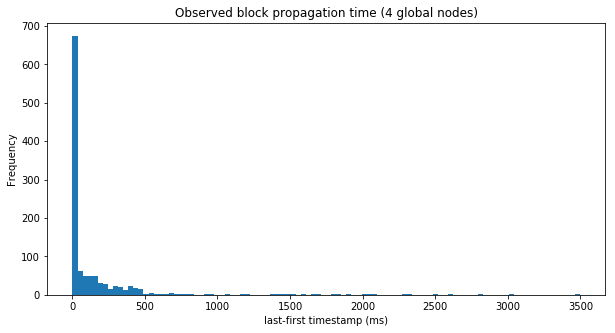

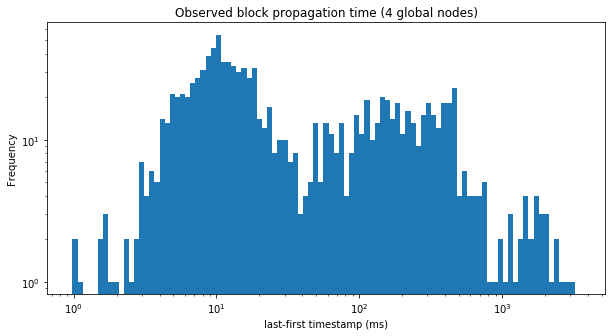

In [8]:
# Linear plot
height_hist = plt.figure(figsize=(10,5), facecolor='w')
plt.hist(global_df['global_prop_time'], bins=100)
plt.xlabel('last-first timestamp (ms)')
plt.ylabel('Frequency')
plt.title('Observed block propagation time (4 global nodes)')

# Log plot
height_hist = plt.figure(figsize=(10,5), facecolor='w')
plt.hist(global_df['global_prop_time'], bins=np.logspace(np.log10(min(global_df['global_prop_time'][global_df['global_prop_time']>0])),np.log10(max(global_df['global_prop_time'])), 100) );plt.yscale('log')
plt.xscale('log')
plt.xlabel('last-first timestamp (ms)')
plt.ylabel('Frequency')
#plt.xlim(min(global_df['global_prop_time'][global_df['global_prop_time']>0]),max(global_df['global_prop_time']))
plt.title('Observed block propagation time (4 global nodes)')

Zoom in on speedy blocks

Text(0.5, 1.0, 'Observed block propagation time (4 global nodes)')

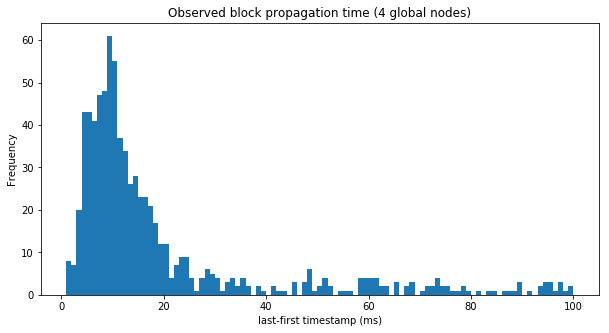

In [9]:
# Linear plot
height_hist = plt.figure(figsize=(10,5), facecolor='w')
plt.hist(global_df['global_prop_time'], bins=np.linspace(1,100,100))
plt.xlabel('last-first timestamp (ms)')
plt.ylabel('Frequency')
plt.title('Observed block propagation time (4 global nodes)')

What does the cumulative distribution look like?

Text(0.5, 1.0, 'Observed block propagation time (4 global nodes)')

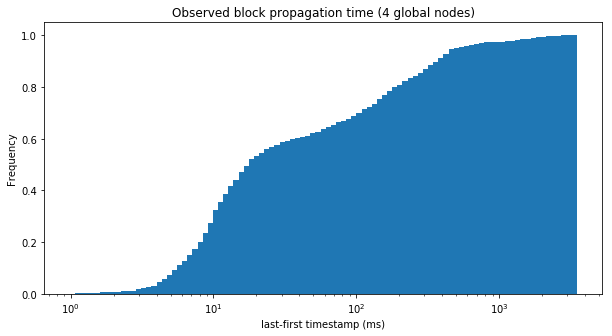

In [10]:
# Log plot
height_hist = plt.figure(figsize=(10,5), facecolor='w')
plt.hist(global_df['global_prop_time'], bins=np.logspace(np.log10(min(global_df['global_prop_time'][global_df['global_prop_time']>0])),np.log10(max(global_df['global_prop_time'])), 100), cumulative=True, density=True);
#plt.yscale('log')
plt.xscale('log')
plt.xlabel('last-first timestamp (ms)')
plt.ylabel('Frequency')
plt.title('Observed block propagation time (4 global nodes)')

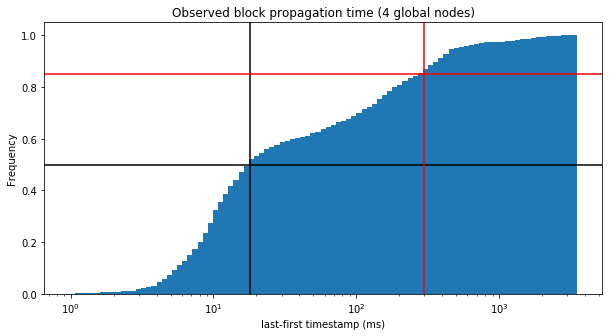

In [11]:
# Log plot
height_hist = plt.figure(figsize=(10,5), facecolor='w')
plt.hist(global_df['global_prop_time'], bins=np.logspace(np.log10(min(global_df['global_prop_time'][global_df['global_prop_time']>0])),np.log10(max(global_df['global_prop_time'])), 100), cumulative=True, density=True);
#plt.yscale('log')
plt.xscale('log')
plt.xlabel('last-first timestamp (ms)')
plt.ylabel('Frequency')
plt.title('Observed block propagation time (4 global nodes)')

plt.axvline(x=18, color='black')
plt.axhline(y=0.5, color='black')

plt.axvline(x=300, color='red')
plt.axhline(y=0.85, color='red')


Spot check some fast and slow blocks

In [12]:
global_df.sort_values(by='global_prop_time').head()

,mumbai_min,mumbai_max,mumbai_prop_time,virginia_min,virginia_max,virginia_prop_time,london_min,london_max,london_prop_time,africa_min,africa_max,africa_prop_time,Height,global_min,global_max,global_prop_time
000000000084537c73dc6318dc21da34fb8ee18a2c0473cc0846c98380e0bb74,1.590716e+09,1.590716e+09,0.872,1.590716e+09,1.590716e+09,0.871,1.590716e+09,1.590716e+09,0.717,1.590716e+09,1.590716e+09,0.897,NaN,1.590716e+09,1.590716e+09,0.980
00000000016ce21bde209faf432687f24c56f66f72f70ccf4b6cc8eb68248dc2,1.590701e+09,1.590701e+09,0.716,1.590701e+09,1.590701e+09,0.963,1.590701e+09,1.590701e+09,0.713,1.590701e+09,1.590701e+09,0.421,847329.0,1.590701e+09,1.590701e+09,0.990
000000000121e410e24f17864852861222835d48e5f322bcd8480368dea2ecd1,1.590706e+09,1.590706e+09,0.893,1.590706e+09,1.590706e+09,0.625,1.590706e+09,1.590706e+09,0.918,1.590706e+09,1.590706e+09,1.038,847393.0,1.590706e+09,1.590706e+09,1.142
000000000247fe90f20e7b1e428cdae6ed9d55f463e9a29f67860cda6ea4f031,1.590701e+09,1.590701e+09,0.524,1.590701e+09,1.590701e+09,1.513,1.590701e+09,1.590701e+09,0.969,1.590701e+09,1.590701e+09,0.769,847330.0,1.590701e+09,1.590701e+09,1.513
0000000000cd43c325e0729e1fb9b95e8eac594bc83cb419b1de50782c1a0c72,1.590699e+09,1.590699e+09,0.593,1.590699e+09,1.590699e+09,1.556,1.590699e+09,1.590699e+09,1.504,1.590699e+09,1.590699e+09,0.630,847313.0,1.590699e+09,1.590699e+09,1.556


In [13]:
global_df.sort_values(by='global_prop_time').tail()

,mumbai_min,mumbai_max,mumbai_prop_time,virginia_min,virginia_max,virginia_prop_time,london_min,london_max,london_prop_time,africa_min,africa_max,africa_prop_time,Height,global_min,global_max,global_prop_time
0000000001add0e0c44b0394cfce2696477610ec32c8b712c00fe38d7d7c206c,1.590757e+09,1.590757e+09,8.938,1.590757e+09,1.590759e+09,2486.880,1.590757e+09,1.590757e+09,8.918,1.590757e+09,1.590757e+09,4.406,848063.0,1.590757e+09,1.590759e+09,2486.896
00000000016d0d3ff3b1ad60e158070b04391ae57e7fcbcdc4198a71c3399ca5,1.590757e+09,1.590757e+09,8.086,1.590757e+09,1.590759e+09,2603.331,1.590757e+09,1.590757e+09,8.095,1.590757e+09,1.590757e+09,2.265,848062.0,1.590757e+09,1.590759e+09,2603.357
00000000010c8bf4ad56a3aa02b46acb7e11d0cbbc9ed7bc9e97d9c416438f94,1.590757e+09,1.590757e+09,16.307,1.590757e+09,1.590759e+09,2798.421,1.590757e+09,1.590757e+09,16.398,1.590757e+09,1.590757e+09,2.801,848061.0,1.590757e+09,1.590759e+09,2798.421
00000000025b45c144ea5ff636eb2fb16efa63b3e6e32e0a92d3fa9b10b49549,1.590756e+09,1.590756e+09,13.772,1.590756e+09,1.590759e+09,3008.781,1.590756e+09,1.590756e+09,15.214,1.590756e+09,1.590756e+09,2.087,848060.0,1.590756e+09,1.590759e+09,3008.781
000000000023f66bddc3710f0be6b0ec8c90d30d971f9636688d3e7aadd59937,1.590756e+09,1.590756e+09,422.472,1.590756e+09,1.590759e+09,3495.512,1.590756e+09,1.590756e+09,422.766,1.590756e+09,1.590756e+09,40.694,848059.0,1.590756e+09,1.590759e+09,3495.512


In [14]:
global_df_clean = global_df.dropna()

Text(0.5, 1.0, 'Observed block propagation time (4 global nodes)')

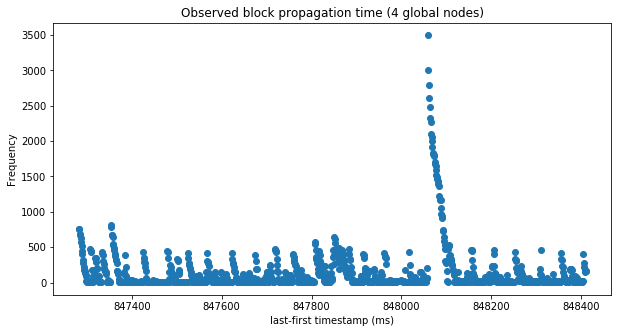

In [15]:
# Log plot
height_hist = plt.figure(figsize=(10,5), facecolor='w')
plt.scatter(x=global_df_clean['Height'], y=global_df_clean['global_prop_time'])
plt.xlabel('last-first timestamp (ms)')
plt.ylabel('Frequency')
plt.title('Observed block propagation time (4 global nodes)')

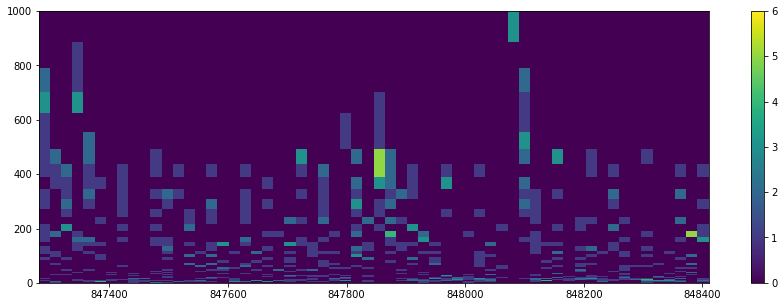

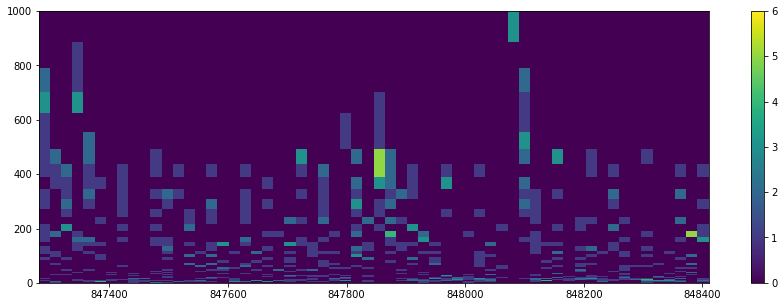

In [16]:
Heatmap(x=global_df_clean['Height'], y=global_df_clean['global_prop_time'], ymax=1000)

In [17]:
if savedata:
    global_df_clean.to_csv('global_df_clean.csv', index_label = 'block_hash')